In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fracture-multi-region-x-ray-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4854718%2F8201044%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240611%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240611T024621Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dace93751985c31eeb71a12eb72450f18a95e61a129b7b7c8caa8806e3c7e13ce446788e9aec22091d7ca6282202cd09c585dad5da7e15faa33f32cf8256ef353ac211bcc3edec23460e7662427b44e054327eb6b4fc00a93a17e4ff48c5a474f1be62e82979d745a007e9a8aae0ad572372c4cf745334318eafbb2c1a1621acb0c1bbee6444e2380ec0449b85b3438a7bbb1e58ead48212db7c878b07ea3bac030698e9753400ecffcb927f68fba68ef9c7b1834bf976abbec8f856a19ffa859982726c2d18b77b580ba88e3c1f5438797476d742ad49403cb7728da3e543b31c29d964d0123268fe25e94968d681baa97c1c2ff697a6c5b1d6dd11065cef3a0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 504652653 bytes downloaded
Downloaded and uncompressed: fracture-multi-region-x-ray-data
Data source import complete.


In [ ]:
import os
import numpy as np
from PIL.Image import Resampling
from keras.utils import load_img, img_to_array


def load_data(data_dir):
    # Initialize empty lists for images and labels
    X = []
    y = []

    # Define image dimensions (adjust as needed)
    img_width, img_height = 64, 64

    for class_dir in os.listdir(data_dir):
        if class_dir in ["fractured", "not fractured"]:
            class_path = os.path.join(data_dir, class_dir)

            # Loop through images in the current subdirectory
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)

                # Load the image
                try:
                    img = load_img(img_path, color_mode="grayscale")
                except OSError as e:
                    if "truncated" in str(e):
                        #print(f"Error: Image {img_path} is truncated. Skipping it.")
                        continue
                    else:
                        raise  # Raise the exception for other errors

                # Resize the image
                img = img.resize((img_width, img_height), resample=Resampling.BICUBIC)

                # Convert to NumPy array
                img_array = img_to_array(img)

                # Reshape for model input (1 channel for grayscale)
                img_array = img_array.reshape(img_width, img_height, 1).astype('float32')

                # Assign labels (0 for "not fractured", 1 for "fractured")
                label = 0 if class_dir == "not fractured" else 1
                X.append(img_array)
                y.append(label)

    return np.array(X), np.array(y)

In [ ]:
train_dir = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train"
valid_dir = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val"
test_dir = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test"

(X_train, y_train) = load_data(train_dir)
(X_valid, y_valid) = load_data(valid_dir)
(X_test, y_test) = load_data(test_dir)

X_train /= 255
X_valid /= 255
X_test /= 255

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_data(X_train, y_train, batch_size=32, img_width=64, img_height=64):
    # Create an ImageDataGenerator instance for data augmentation
    datagen = ImageDataGenerator(
        # rotation_range=10,      # Rotate images randomly by up to 20 degrees
        # width_shift_range=0.1,  # Shift images horizontally by up to 10% of the width
        # height_shift_range=0.1, # Shift images vertically by up to 10% of the height
        # shear_range=0.2,        # Apply shear transformation
        # zoom_range=0.1,         # Zoom in/out on images by up to 20%
        horizontal_flip=True,  # Flip images horizontally
        # vertical_flip=True,    # Flip images vertically
        # fill_mode='nearest'     # Fill missing pixels using the nearest value
    )

    # Fit the ImageDataGenerator on the training data
    datagen.fit(X_train)

    # Create a generator to yield augmented data batches
    aug_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

    # Return the augmented data generator
    return aug_generator


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.initializers import Zeros, GlorotNormal

def CNN():
  model = Sequential()

  model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), activation='relu', input_shape=(64, 64, 1),
                  kernel_initializer=GlorotNormal(), bias_initializer=Zeros()))
  model.add(BatchNormalization())

  model.add(Conv2D(16, kernel_size=(3, 3), strides=(3, 3), activation='relu',
                  kernel_initializer=GlorotNormal(), bias_initializer=Zeros()))
  model.add(MaxPooling2D(pool_size=(3, 3)))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(128, activation='relu', kernel_initializer=GlorotNormal(), bias_initializer=Zeros()))
  model.add(Dropout(0.5))

  model.add(Dense(1, activation='sigmoid', kernel_initializer=GlorotNormal(), bias_initializer=Zeros()))

  model.summary()
  model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

  return model

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [ ]:
BATCH_SIZE = 32
EPOCHS = 20

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 21, 21, 32)        320       
                                                                 
 batch_normalization_14 (Ba  (None, 21, 21, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 7, 16)          4624      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 2, 2, 16)          0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Ba  (None, 2, 2, 16)          64        
 tchNormalization)                                               
                                                      

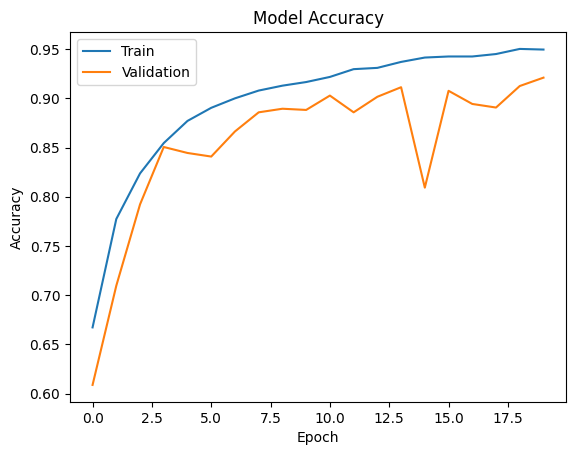

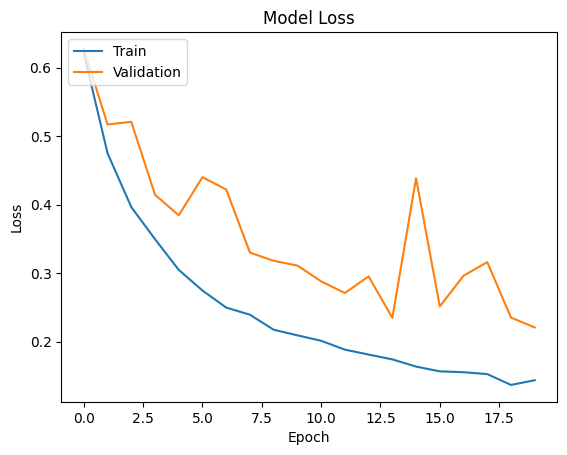

In [ ]:
model = CNN()
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(X_valid, y_valid))
print(model.evaluate(X_test, y_test))
plot_accuracy(history)
plot_loss(history)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 21, 21, 32)        320       
                                                                 
 batch_normalization_28 (Ba  (None, 21, 21, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_29 (Conv2D)          (None, 7, 7, 16)          4624      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 2, 2, 16)          0         
 ng2D)                                                           
                                                                 
 batch_normalization_29 (Ba  (None, 2, 2, 16)          64        
 tchNormalization)                                               
                                                     

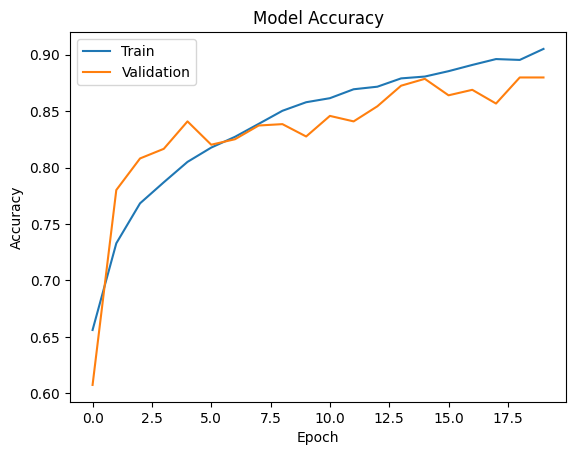

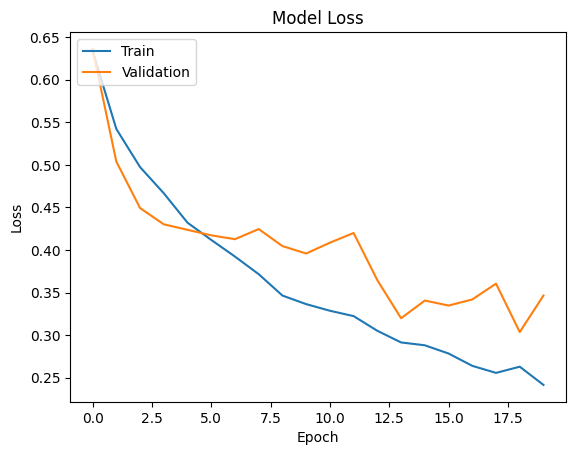

In [ ]:
augmented_generator = augment_data(X_train, y_train)

model = CNN()
history = model.fit(augmented_generator, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(X_valid, y_valid))
print(model.evaluate(X_test, y_test))
plot_accuracy(history)
plot_loss(history)

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tqdm import tqdm


def shuffle_data(x_train, y_train):
    # Generate random permutation of indices
    num_samples = x_train.shape[0]
    permutation = np.random.permutation(num_samples)

    # Shuffle both x_train and y_train using the same permutation
    shuffled_x_train = x_train[permutation]
    shuffled_y_train = y_train[permutation]

    return shuffled_x_train, shuffled_y_train


def add_synthetic_data(data_dir, x_train, y_train, label):
  synthetic_x_train = []
  synthetic_y_train = []
  for img_name in tqdm(os.listdir(data_dir)):
      img_path = os.path.join(data_dir, img_name)

      # Load the image
      try:
          img = load_img(img_path, color_mode="grayscale")
      except OSError as e:
          if "truncated" in str(e):
              #print(f"Error: Image {img_path} is truncated. Skipping it.")
              continue
          else:
              raise  # Raise the exception for other errors

      # Convert to NumPy array
      img_array = img_to_array(img)

      # Reshape for model input (1 channel for grayscale)
      img_array = img_array.reshape(64, 64, 1).astype('float32')

      synthetic_x_train.append(img_array)
      synthetic_y_train.append(label)

  # Convert lists to Numpy arrays
  synthetic_x_train = np.array(synthetic_x_train)
  synthetic_y_train = np.array(synthetic_y_train)

  # Concatenate with existing data
  if x_train is not None:
    synthetic_x_train = np.concatenate((x_train, synthetic_x_train), axis=0)
  if y_train is not None:
    synthetic_y_train = np.concatenate((y_train, synthetic_y_train), axis=0)

  # shuffle the data
  synthetic_x_train, synthetic_y_train = shuffle_data(synthetic_x_train, synthetic_y_train)

  return synthetic_x_train, synthetic_y_train



In [ ]:
UNFRACTURED_SYNTHETIC_DATA_DIR = '/content/drive/MyDrive/unfrac_generated_images/'
FRACTURED_SYNTHETIC_DATA_DIR = '/content/drive/MyDrive/generated_fractured_images/'

X_train_synthetic = X_train.copy()
y_train_synthetic = y_train.copy()
print(X_train_synthetic.shape, y_train_synthetic.shape)

X_train_synthetic, y_train_synthetic = add_synthetic_data(UNFRACTURED_SYNTHETIC_DATA_DIR, X_train_synthetic, y_train_synthetic, 0)
print(X_train_synthetic.shape, y_train_synthetic.shape)

X_train_synthetic, y_train_synthetic = add_synthetic_data(FRACTURED_SYNTHETIC_DATA_DIR, X_train_synthetic, y_train_synthetic, 1)
print(X_train_synthetic.shape, y_train_synthetic.shape)

model = CNN()
history = model.fit(X_train_synthetic, y_train_synthetic, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(X_valid, y_valid))
print(model.evaluate(X_test, y_test))
plot_accuracy(history)
plot_loss(history)

(9240, 64, 64, 1) (9240,)


  0%|          | 0/4830 [00:00<?, ?it/s]

(1, 64, 64, 1) (1,)


KeyboardInterrupt: 

In [ ]:
X_train_synthetic, y_train_synthetic = add_synthetic_data(UNFRACTURED_SYNTHETIC_DATA_DIR, None, None, 0)
print(X_train_synthetic.shape, y_train_synthetic.shape)

X_train_synthetic, y_train_synthetic = add_synthetic_data(FRACTURED_SYNTHETIC_DATA_DIR, X_train_synthetic, y_train_synthetic, 1)
print(X_train_synthetic.shape, y_train_synthetic.shape)

model = CNN()

# warm start model on synthetic data
history = model.fit(X_train_synthetic, y_train_synthetic, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(X_valid, y_valid))

# train model on real data
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(X_valid, y_valid))

print(model.evaluate(X_test, y_test))
plot_accuracy(history)
plot_loss(history)

100%|██████████| 4830/4830 [02:22<00:00, 33.79it/s] 


(4830, 64, 64, 1) (4830,)


  1%|          | 116/10500 [00:47<2:01:07,  1.43it/s]